# Pipeline

This pipeline includes all steps in a single notebook (For Google Colab setup and testing purposes). It is currently a work-in-progress, for now, please visit ./notebooks for the individual steps.

In [232]:
import sys

# The current environment is automatically detected
# and set to either "GOOGLE_COLAB" or "LOCAL"
# depending on where the script is being run.

CURRENT_ENVIRONMENT = "GOOGLE_COLAB" if "google.colab" in sys.modules else "LOCAL"

In [233]:
import os
import shutil

if CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # If the utils directory exists, delete it
    if os.path.exists('/content/utils'):
        shutil.rmtree('/content/utils')

    # Copy the utils.zip file to the current directory
    !cp /content/drive/MyDrive/utils.zip /content/utils.zip

    # Unzip the utils.zip file
    !unzip -q /content/utils.zip -d /content/utils

    # Delete the utils.zip file
    !rm /content/utils.zip

In [234]:
# Set to True if you want to skip all EDA
# and data preprocessing steps, otherwise set to False.
SKIP_TO_TRAINING = True

# Set to True if you want to train all models,
# otherwise set to False to save time.
TRAIN_ALL_MODELS = False

# Set to True if you want to generate all train/val/test
# splits, otherwise set to False to save time.
# FORCE_GENERATE_SPLITS = ["Category", "Style"]
FORCE_GENERATE_SPLITS = []

# Update to 1 to use the full preprocessed dataset,
# by default, our models are only trained on 20% of the
# dataset on local and 50% of the dataset on Google Colab.
# SAMPLE_FRACTION = 0.5 if CURRENT_ENVIRONMENT == "GOOGLE_COLAB" else 0.2

# Use full dataset
# SAMPLE_FRACTION = 0.005
SAMPLE_FRACTION = 0.05

# Set the random seed for reproducibility
RANDOM_SEED = 42

# Set the test and evaluation sizes
TEST_SIZE = 0.2  # 20% of the data
VAL_SIZE = 0.1  # 10% of the data

# Training callback constants
EPOCHS = 200
BATCH_SIZE = 128 if CURRENT_ENVIRONMENT == "GOOGLE_COLAB" else 32
EARLY_STOPPING_PATIENCE = 10
LEARNING_RATE_PATIENCE = 5

In [235]:
MODELS = [
    {
        "task": 1,
        "models": [
            {
                "name": "CNN",
                "train": False,
            }
        ],
    },
    {
        "task": 2,
        "models": [
            {
                "name": "Siamese",
                "train": False,
            }
        ],
    },
    {
        "task": 3,
        "models": [
            {
                "name": "CNN",
                "train": False,
            },
            {
                "name": "ResNet4",
                "train": False,
            },
            {
                "name": "ResNet8",
                "train": False,
            },
        ],
    },
]

In [236]:
def generate_model_save_dir(group, name, fraction):
    size = "large" if fraction >= 0.5 else "small"
    fraction = round(fraction * 100) if fraction >= 0.01 else fraction * 100
    name = name.lower()
    return f"t{group}_{size}_{fraction}_{name}"


# Update model save directory
for tasks in MODELS:
    for model in tasks["models"]:
        model["save_dir"] = generate_model_save_dir(
            tasks["task"],
            model["name"],
            SAMPLE_FRACTION,
        )

# Display the model save directories
for tasks in MODELS:
    for model in tasks["models"]:
        print(f"Model save directory: {model['save_dir']}")

Model save directory: t1_small_5_cnn
Model save directory: t2_small_5_siamese
Model save directory: t3_small_5_cnn
Model save directory: t3_small_5_resnet4
Model save directory: t3_small_5_resnet8


In [237]:
if CURRENT_ENVIRONMENT == "LOCAL":
    from utils.constants import *
elif CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
    from utils.constants_colab import *
elif CURRENT_ENVIRONMENT == "KAGGLE":
    from utils.constants_kaggle import *

In [238]:
import os
from utils.zipper import read_file, write_file

install_file = os.path.join(DATA_DIR, "install.txt")

# Create the directory if it does not exist
os.makedirs(DATA_DIR, exist_ok=True)

install_content = read_file(install_file)

if ENVIRONMENT == "LOCAL":
    requirements_file = "requirements.txt"
    requirements_content = read_file(requirements_file)
    if install_content != requirements_content:
        get_ipython().system("pip install -r requirements.txt")
        write_file(install_file, requirements_content)
elif ENVIRONMENT == "GOOGLE_COLAB" and not SKIP_TO_TRAINING:
    if install_content != "imagehash":
        get_ipython().system("pip install imagehash")
        write_file(install_file, "imagehash")

In [239]:
if ENVIRONMENT == "LOCAL":
    from utils.cache import reload_custom_libraries

    # Refresh library cache
    reload_custom_libraries()

In [240]:
if ENVIRONMENT == "LOCAL":
    from utils.zipper import zip_dir

    # Zip the reloaded libraries to be used in Google Colab
    zip_dir(UTILS_DIR, f"{ZIPPED_RESOURCES_DIR}/utils.zip")

In [241]:
from utils.zipper import unzip_file

if ENVIRONMENT != "LOCAL" or (ENVIRONMENT == "LOCAL" and not SKIP_TO_TRAINING):
    # Check if the zipped preprocessed datasets file exists and ROOT_DATASET_DIR does not exist
    if os.path.exists(PREPROCESSED_DATASETS_ZIP):
        print("Cached preprocessed datasets found.")
        if not os.path.exists(ROOT_DATASET_DIR):
            print("Extracting preprocessed datasets...")
            unzip_file(
                PREPROCESSED_DATASETS_ZIP,
                PREPROCESSED_DATASETS_EXTRACT_DIR,
            )
            print("Preprocessed datasets extracted.")
        else:
            print("Directory with preprocessed datasets found. Skipping extraction...")
    else:
        print("Cached preprocessed datasets not found. Skipping extraction...")

In [242]:
if ENVIRONMENT == "LOCAL" and not SKIP_TO_TRAINING:
    import tensorflow as tf
    import tensorflow_hub as hub

    print("TF version:", tf.__version__)
    print("Hub version:", hub.__version__)
    print(
        "GPU is",
        "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE",
    )

In [243]:
if not SKIP_TO_TRAINING:
    from tqdm.notebook import tqdm
    import zipfile
    import shutil
    import os

    # if force unzip or DATASET_DIR doesn't exist or empty
    if FORCE_UNZIP or not os.path.isdir(DATASET_DIR) or not os.listdir(DATASET_DIR):
        if not os.path.isdir(f"{DATASET_EXTRACT_DIR}/Furniture_Data"):
            print("Starting unzip process...")
            # Extract the zip file
            with zipfile.ZipFile(RAW_DATASET_ZIP, "r") as zip_ref:
                zip_ref.extractall(DATASET_EXTRACT_DIR)
            print("Unzip process completed.")
            print("Checking for `__MACOSX` directory...")

            # Check if the `__MACOSX` directory exists
            if os.path.isdir(MACOS_DIR):
                # Delete the `__MACOSX` directory
                shutil.rmtree(MACOS_DIR)
                print("`__MACOSX` directory found and deleted.")
            else:
                print("`__MACOSX` directory not found. Skipping deletion.")

            if ENVIRONMENT == "GOOGLE_COLAB":
                # Check if the new dataset already directory exists
                print("Checking for existing train dataset directory...")
                if os.path.isdir(DATASET_DIR):
                    # Delete the new dataset directory
                    shutil.rmtree(DATASET_DIR)
                    print("Existing train dataset directory found and deleted.")
                # Move the extracted dataset to the correct directory
                if os.path.isdir(f"{DATASET_EXTRACT_DIR}/Furniture_Data"):
                    print("Moving extracted dataset to the correct directory...")
                    shutil.move(
                        f"{DATASET_EXTRACT_DIR}/Furniture_Data", ROOT_DATASET_DIR
                    )
                    print("Dataset moved successfully.")
            elif ENVIRONMENT == "LOCAL":
                # Rename the extracted directory to the correct directory
                if os.path.isdir(f"{DATASET_EXTRACT_DIR}/Furniture_Data"):
                    print("Renaming extracted dataset directory...")
                    os.rename(f"{DATASET_EXTRACT_DIR}/Furniture_Data", DATASET_DIR)
                    print("Dataset renamed successfully.")
    else:
        print(
            "Skipping unzip process as DATASET_DIR exists and FORCE_UNZIP is not set."
        )

In [244]:
if not SKIP_TO_TRAINING:
    from IPython.display import display
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from PIL import Image
    from utils.image_process import (
        get_category_styles,
        process_images,
        get_category_image_paths,
        resize_images,
        get_majority_class,
        identify_minority_classes,
        calculate_category_oversampling,
        calculate_style_oversampling,
        oversample_minority_classes,
    )

In [245]:
if not SKIP_TO_TRAINING:
    categories = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]

    paths = {
        category: get_category_image_paths(DATASET_DIR, category)
        for category in categories
    }

    print("Successfully extracted all paths!")

In [246]:
if not SKIP_TO_TRAINING:
    # Calculate the total

    total = 0

    # Print the amount for each category

    for category in categories:

        amount = len(paths[category])

        print(f"Amount of {category}: {amount}")

        total += amount

    # Print the total

    print("Total:", total)

In [247]:
if not SKIP_TO_TRAINING:
    plt.bar(paths.keys(), [len(v) for v in paths.values()], width=0.5)
    plt.title("Number of images in each category")
    plt.xlabel("Categories")
    plt.ylabel("Amount")
    plt.show()

## Get duplicate images from each categories
### Check duplicants and remove duplicants from each categories

In [248]:
if not SKIP_TO_TRAINING:
    # Create a new dictionary to store the paths and image sizes for each category
    data = {}
    for category, items in paths.items():
        imageSizes = process_images(items, category, DATASET_DIR)
        data[category] = {
            "paths": get_category_image_paths(CLEANED_DATASET_DIR, category),
            "imageSizes": imageSizes,
        }

    paths = {
        category: get_category_image_paths(CLEANED_DATASET_DIR, category)
        for category in categories
    }

    print("Successfully extracted all paths and image sizes!")

### Recheck the categories after removing duplicants

In [249]:
if not SKIP_TO_TRAINING:
    # Calculate the total
    total = 0

    # Print the amount for each category
    for category in categories:
        amount = len(data[category]["paths"])
        print(f"Amount of {category}: {amount}")
        total += amount

    # Print the total
    print("Total:", total)

### Visualization

In [250]:
if not SKIP_TO_TRAINING:
    plt.bar(
        categories, [len(data[category]["paths"]) for category in categories], width=0.5
    )
    plt.title("Number of images in each category")
    plt.xlabel("Categories")
    plt.ylabel("Amount")

-   In the plot we can see the differences between of the amount in different columns. Because of that, we will need to check for the imbalances of our dataset

## Get different amount of image size of each category

In [251]:
if not SKIP_TO_TRAINING:
    # Define a dictionary to store the dataframes
    # each category in df_dims is data[category][imageSizes]
    df_dims = {
        category: pd.DataFrame(
            data[category]["imageSizes"], columns=["width", "height"]
        )
        for category in categories
    }

    print("Successfully extracted all dimensions!")

In [252]:
if not SKIP_TO_TRAINING:
    import matplotlib.pyplot as plt

    # Define the number of rows and columns for the subplot grid
    n_rows = 2
    n_cols = 3

    # Create the subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

    # Flatten the axes array
    axs = axs.flatten()

    # Iterate over the categories and axes
    for ax, category in zip(axs, categories):
        # Create the scatter plot for the current category
        df_dims[category].plot.scatter(
            x="width", y="height", ax=ax, title=category.capitalize()
        )

    # Adjust the layout
    plt.tight_layout()
    plt.show()

In [253]:
if not SKIP_TO_TRAINING:
    # Iterate over the categories
    for category in categories:
        print(category.capitalize())
        display(df_dims[category].describe().T)

- The dataset contains 6 categories of items with 90083 items total
- The dataset contains all file with JPEG type
- The dataset contains image mainly in two dimensions: 224x224 and 350x350. However there are one anomaly dimensions in the table category which is: 500x446

## Data Preprocessing

We will start with resizing all images to 350x350. Here are some reasons:
- The vast majority of the images are already at 350x350. Upscaling the smaller images will introduce minimal distortion compared to downscaling the majority to 224x224.
- Upscaling generally retains more information from the original image than downscaling. While some interpolation artifacts might be introduced, they are less likely to significantly impact model performance compared to the information loss from downscaling.
- The single image with a size of 500x448 is an outlier. which we can either upscale it to match the majority or exclude it from our dataset without significant impact.

In [254]:
if not SKIP_TO_TRAINING:
    Image.open(data["beds"]["paths"][1])

In [255]:
if not SKIP_TO_TRAINING:
    for category in categories:
        print(
            f"Number of images in category '{category}': {len(data[category]['paths'])}"
        )

        # Total number of images
        total = sum(len(data[category]["paths"]) for category in categories)
        print(f"Total number of images: {total}")

In [256]:
if not SKIP_TO_TRAINING:
    # check all file extensions in data[*]["paths"]
    for category in categories:
        print(f"Checking file extensions for category '{category}'")
        for img_path in data[category]["paths"]:
            if not img_path.endswith((".jpg", ".jpeg", ".png")):
                print(f"Invalid file extension: {img_path}")
                break
        print(f"All file extensions are valid for category '{category}'")

In [257]:
if not SKIP_TO_TRAINING:
    size = (350, 350)

    for category in data.keys():
        resize_images(data, category, size)

In [258]:
if not SKIP_TO_TRAINING:
    # Display the minority classes
    majority_class, max_count = get_majority_class(data)
    minority_classes = identify_minority_classes(data, 1.0)

    # Display the classes
    print("Majority class:", majority_class)
    print("Minority classes:", minority_classes)

In [259]:
if not SKIP_TO_TRAINING:
    import seaborn as sns

    # Set the style of seaborn
    sns.set(style="whitegrid")

    # calculate the how much oversampling is needed
    oversampling = calculate_category_oversampling(
        data, minority_classes + [majority_class], max_count
    )

    # Visualize the data
    categories = list(data.keys())
    original_counts = [len(data[category]["paths"]) for category in categories]
    oversampled_counts = [oversampling.get(category, 0) for category in categories]

    # Create DataFrame for seaborn
    df = pd.DataFrame(
        {
            "Category": categories,
            "Original": original_counts,
            "Oversampled": oversampled_counts,
        }
    )

    # Melt DataFrame
    df_melt = df.melt(id_vars="Category", var_name="Type", value_name="Count")

    # Create barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Category", y="Count", hue="Type", data=df_melt, palette="muted")

    # Add some text for labels, title and axes ticks
    plt.title("Number of images in each category with oversampling")
    plt.xlabel("Categories")
    plt.ylabel("Amount")

    plt.show()

    print("Total number of images before oversampling:", sum(original_counts))
    print(
        "Total number of images after oversampling:",
        sum(original_counts) + sum(oversampled_counts),
    )

In [260]:
if not SKIP_TO_TRAINING:
    # Set the style of seaborn
    sns.set(style="whitegrid")

    # Prepare data for visualization
    categories, styles, original_counts = [], [], []

    for category, paths in data.items():
        style_counts = {}
        for path in paths["paths"]:
            # Extract style from the path
            style = os.path.dirname(path).split("/")[-1]
            if style not in style_counts:
                style_counts[style] = 0
            style_counts[style] += 1

        for style, count in style_counts.items():
            categories.append(category)
            styles.append(style)
            original_counts.append(count)

    # Create DataFrame for seaborn
    df = pd.DataFrame(
        {
            "Category": categories,
            "Style": styles,
            "Original": original_counts,
        }
    )

    # Melt DataFrame
    df_melt = df.melt(
        id_vars=["Category", "Style"], var_name="Type", value_name="Count"
    )

    # Create barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Category", y="Count", hue="Style", data=df_melt, palette="muted")

    # Add some text for labels, title and axes ticks
    plt.title("Number of images in each style within each category before oversampling")
    plt.xlabel("Categories")
    plt.ylabel("Amount")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    plt.show()

In [261]:
if not SKIP_TO_TRAINING:
    # Set the style of seaborn
    sns.set(style="whitegrid")

    # calculate the how much oversampling is needed
    oversampling = calculate_style_oversampling(
        data, minority_classes + [majority_class]
    )

    # Prepare data for visualization
    categories, styles, original_counts, oversampled_counts = [], [], [], []

    for category, paths in data.items():
        style_counts = {}
        for path in paths["paths"]:
            # Extract style from the path
            style = os.path.dirname(path).split("/")[-1]
            if style not in style_counts:
                style_counts[style] = 0
            style_counts[style] += 1

        for style, count in style_counts.items():
            categories.append(category)
            styles.append(style)
            original_counts.append(count)
            oversampled_counts.append(oversampling.get(category, {}).get(style, 0))

    # Create DataFrame for seaborn
    df = pd.DataFrame(
        {
            "Category": categories,
            "Style": styles,
            "Original": original_counts,
            "Oversampled": oversampled_counts,
        }
    )

    # Melt DataFrame
    df_melt = df.melt(
        id_vars=["Category", "Style"], var_name="Type", value_name="Count"
    )

    # Create barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Category", y="Count", hue="Style", data=df_melt, palette="muted")

    # Add some text for labels, title and axes ticks
    plt.title("Number of images in each style within each category with oversampling")
    plt.xlabel("Categories")
    plt.ylabel("Amount")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    plt.show()

In [262]:
if not SKIP_TO_TRAINING:
    # print all projected sum to check if all categories have roughly the same amount of images
    categories = list(data.keys())
    for category in categories:
        oversampling_count = sum(oversampling.get(category, {}).values())
        print(
            f"Projected sum for category '{category}':",
            len(data[category]["paths"]) + oversampling_count,
        )

    # Create a bar chart of the number of images in each category
    plt.bar(
        categories,
        [len(data[category]["paths"]) + oversampling_count for category in categories],
        width=0.5,
    )
    plt.title("Number of images in each category")
    plt.xlabel("Categories")
    plt.ylabel("Amount")
    plt.show()

In [263]:
if not SKIP_TO_TRAINING:
    print("Total number of images before oversampling:", sum(original_counts))
    print(
        "Total number of images after oversampling:",
        sum(original_counts) + sum(oversampled_counts),
    )

In [264]:
if not SKIP_TO_TRAINING:
    # Oversample minority classes
    data = oversample_minority_classes(data, minority_classes + [majority_class])

    # Calculate the total
    total = 0
    # Print the amount for each category
    for category in categories:
        amount = len(data[category]["paths"])
        print(f"Amount of {category}: {amount}")
        total += amount

    # Print the total
    print("Total:", total)

In [265]:
if not SKIP_TO_TRAINING:
    plt.bar(
        categories, [len(data[category]["paths"]) for category in categories], width=0.5
    )
    plt.title("Number of images in each category")
    plt.xlabel("Categories")
    plt.ylabel("Amount")

In [266]:
if not SKIP_TO_TRAINING:
    paths = {
        category: get_category_image_paths(PROCESSED_DATASET_DIR, category)
        for category in categories
    }

    for category, items in paths.items():
        imageSizes = process_images(items, category, PROCESSED_DATASET_DIR)
        data[category] = {
            "paths": get_category_image_paths(PROCESSED_DATASET_DIR, category),
            "imageSizes": imageSizes,
        }

    print("Successfully extracted all paths and image sizes!")

In [267]:
from utils.converter import convert_to_df

raw_dataset_df = convert_to_df(DATASET_DIR, TRAIN_DATA_CSV)
cleaned_dataset_df = convert_to_df(CLEANED_DATASET_DIR, CLEANED_TRAIN_DATA_CSV)
processed_dataset_df = convert_to_df(PROCESSED_DATASET_DIR, PROCESSED_TRAIN_DATA_CSV)

CSV file already exists at ./data/datasets/raw.csv. Loading from cache...
CSV file already exists at ./data/datasets/cleaned.csv. Loading from cache...
CSV file already exists at ./data/datasets/processed.csv. Loading from cache...


### Task 1:

#### Model 1: Convolutional Neural Network (CNN) Model

Convolutional Neural Networks (CNNs) are a class of deep learning models that are primarily used for analyzing visual data. CNNs are particularly effective for tasks such as image classification, object detection, and facial recognition.

The CNN model in this code is a simple yet effective architecture for image classification. It consists of two convolutional layers, each followed by a max pooling layer, a flattening layer, and two dense layers.

The convolutional layers are the first layers of the network, where the model learns several high-level features of the images. Each convolutional layer in this model uses a 3x3 kernel and a ReLU (Rectified Linear Unit) activation function. The 'same' padding is used to preserve the spatial dimensions of the volume such that the output volume size matches the input volume size.

The max pooling layers are used to reduce the spatial dimensions of the output volume. It is a down-sampling operation that is performed after each convolutional layer to reduce the dimensionality and to prevent overfitting.

The flattening layer is used to convert the 2D matrix into a 1D vector, which can be fed into the dense layers.

The dense layers, also known as fully connected layers, perform classification on the features extracted by the convolutional layers and down-sampled by the max pooling layers. The final dense layer uses a softmax activation function to output a probability distribution over the 6 classes of furniture.

The model is trained using the Adam optimizer and the sparse categorical cross-entropy loss function, which is suitable for multi-class classification problems. The model's performance is evaluated using accuracy as the metric.

The model is trained on a training dataset and validated on a validation dataset. After training, the model is saved to a file and then evaluated on a test dataset to measure its performance.

In [268]:
# Task 1 Models
task_1_model_1 = MODELS[0]["models"][0]  # CNN

In [269]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TARGET = "Category"

# Create a data generator
datagen = ImageDataGenerator(rescale=1.0 / 255)

if task_1_model_1["train"] or TRAIN_ALL_MODELS or TARGET in FORCE_GENERATE_SPLITS:
    from sklearn.model_selection import train_test_split

    # Take a sample of the entire dataset, stratifying on TARGET
    sample_df = processed_dataset_df.groupby(TARGET, group_keys=False).apply(
        lambda x: x.sample(frac=SAMPLE_FRACTION, random_state=RANDOM_SEED)
    )

    train_df, temp_df = train_test_split(
        sample_df,
        test_size=TEST_SIZE + VAL_SIZE,
        random_state=RANDOM_SEED,
        stratify=sample_df[TARGET],
    )

    val_df, test_df = train_test_split(
        temp_df,
        test_size=TEST_SIZE / (TEST_SIZE + VAL_SIZE),
        random_state=RANDOM_SEED,
        stratify=temp_df[TARGET],
    )

    # Load images from dataframes for Category classification
    train_generator_category = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="Full_Path",
        y_col=TARGET,
        target_size=(350, 350),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True,
    )

    val_generator_category = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col="Full_Path",
        y_col=TARGET,
        target_size=(350, 350),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False,
    )

    test_generator_category = datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="Full_Path",
        y_col=TARGET,
        target_size=(350, 350),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False,
    )

In [270]:
from tensorflow.keras import layers, Model, Input

input_layer = Input(shape=(350, 350, 3))

# Initial layers
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Layer Block 1
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Layer Block 2
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Flatten and Fully-connected layers
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(6, activation="softmax")(x)

task_1_cnn = Model(inputs=input_layer, outputs=output_layer)

In [271]:
target_model = task_1_model_1

from utils.models import train_model

if target_model["train"] or TRAIN_ALL_MODELS:
    train_model(
        model=task_1_cnn,
        model_conf=target_model,
        environment=ENVIRONMENT,
        epochs=EPOCHS,
        sample_fraction=SAMPLE_FRACTION,
        early_stopping_patience=EARLY_STOPPING_PATIENCE,
        learning_rate_patience=LEARNING_RATE_PATIENCE,
        train_generator=train_generator_category,
        val_generator=val_generator_category,
        test_generator=test_generator_category,
        root_dir=(
            f"{GOOGLE_DRIVE_ROOT_DIR}/Models"
            if ENVIRONMENT == "GOOGLE_COLAB"
            else MODEL_DIR
        ),
    )

### Task 3:

#### Model 1: Convolutional Neural Network (CNN) Model

In [272]:
# Task 3 Models
task_3_model_1 = MODELS[2]["models"][0]  # CNN
task_3_model_2 = MODELS[2]["models"][1]  # ResNet (4 blocks)
task_3_model_3 = MODELS[2]["models"][2]  # ResNet (8 blocks)

In [273]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TARGET = "Style"

# Create a data generator
datagen = ImageDataGenerator(rescale=1.0 / 255)

if (
    task_3_model_1["train"]
    or task_3_model_2["train"]
    or task_3_model_3["train"]
    or TRAIN_ALL_MODELS
    or TARGET in FORCE_GENERATE_SPLITS
):
    from sklearn.model_selection import train_test_split

    # Take a sample of the entire dataset, stratifying on TARGET
    sample_df = processed_dataset_df.groupby(TARGET, group_keys=False).apply(
        lambda x: x.sample(frac=SAMPLE_FRACTION, random_state=RANDOM_SEED)
    )

    train_df, temp_df = train_test_split(
        sample_df,
        test_size=TEST_SIZE + VAL_SIZE,
        random_state=RANDOM_SEED,
        stratify=sample_df[TARGET],
    )

    val_df, test_df = train_test_split(
        temp_df,
        test_size=TEST_SIZE / (TEST_SIZE + VAL_SIZE),
        random_state=RANDOM_SEED,
        stratify=temp_df[TARGET],
    )

    # Load images from dataframes for Category classification
    train_generator_style = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="Full_Path",
        y_col=TARGET,
        target_size=(350, 350),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True,
    )

    val_generator_style = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col="Full_Path",
        y_col=TARGET,
        target_size=(350, 350),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False,
    )

    test_generator_style = datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="Full_Path",
        y_col=TARGET,
        target_size=(350, 350),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False,
    )

In [274]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.regularizers import l2

input_layer = Input(shape=(350, 350, 3))

# Initial layers
x = layers.Conv2D(
    16,
    (3, 3),
    activation="relu",
    padding="same",
    kernel_regularizer=l2(0.001),
)(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Convolution Block 1
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Convolution Block 2
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Fully-connected layers
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(17, activation="softmax")(x)

task_3_cnn = Model(inputs=input_layer, outputs=output_layer)

In [275]:
target_model = task_3_model_1

from utils.models import train_model

if target_model["train"] or TRAIN_ALL_MODELS:
    train_model(
        model=task_3_cnn,
        model_conf=target_model,
        environment=ENVIRONMENT,
        epochs=EPOCHS,
        sample_fraction=SAMPLE_FRACTION,
        early_stopping_patience=EARLY_STOPPING_PATIENCE,
        learning_rate_patience=LEARNING_RATE_PATIENCE,
        train_generator=train_generator_style,
        val_generator=val_generator_style,
        test_generator=test_generator_style,
        root_dir=(
            f"{GOOGLE_DRIVE_ROOT_DIR}/Models"
            if ENVIRONMENT == "GOOGLE_COLAB"
            else MODEL_DIR
        ),
    )

In [276]:
from tensorflow.keras import layers, Model, Input

input_layer = Input(shape=(350, 350, 3))

# Initial layers
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Residual Block 1
shortcut = x
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(32, (1, 1), padding="same")(shortcut)
x = layers.Add()([shortcut, x])  # Residual Connection
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Residual Block 2
shortcut = x
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(64, (1, 1), padding="same")(shortcut)
x = layers.Add()([shortcut, x])  # Residual Connection
x = layers.Activation("relu")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Additional layers
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Fully-connected layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)  # Increased units
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(17, activation="softmax")(x)

task_3_resnet_4 = Model(inputs=input_layer, outputs=output_layer)

In [277]:
target_model = task_3_model_2

from utils.models import train_model

if target_model["train"] or TRAIN_ALL_MODELS:
    train_model(
        model=task_3_resnet_4,
        model_conf=target_model,
        environment=ENVIRONMENT,
        epochs=EPOCHS,
        sample_fraction=SAMPLE_FRACTION,
        early_stopping_patience=EARLY_STOPPING_PATIENCE,
        learning_rate_patience=LEARNING_RATE_PATIENCE,
        train_generator=train_generator_style,
        val_generator=val_generator_style,
        test_generator=test_generator_style,
        root_dir=(
            f"{GOOGLE_DRIVE_ROOT_DIR}/Models"
            if ENVIRONMENT == "GOOGLE_COLAB"
            else MODEL_DIR
        ),
    )

In [278]:
from tensorflow.keras import layers, Model, Input

input_layer = Input(shape=(350, 350, 3))

# Initial layers
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Residual Block 1
shortcut = x
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(32, (1, 1), padding="same")(shortcut)
x = layers.Add()([shortcut, x])  # Residual Connection
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Residual Block 2
shortcut = x
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(64, (1, 1), padding="same")(shortcut)
x = layers.Add()([shortcut, x])  # Residual Connection
x = layers.Activation("relu")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Residual Block 3
shortcut = x
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(128, (1, 1), padding="same")(shortcut)
x = layers.Add()([shortcut, x])  # Residual Connection
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Residual Block 4
shortcut = x
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(256, (1, 1), padding="same")(shortcut)
x = layers.Add()([shortcut, x])  # Residual Connection
x = layers.Activation("relu")(x)
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Additional layers
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Fully-connected layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)  # Increased units
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(17, activation="softmax")(x)

task_3_resnet_8 = Model(inputs=input_layer, outputs=output_layer)

In [279]:
target_model = task_3_model_3

from utils.models import train_model

if target_model["train"] or TRAIN_ALL_MODELS:
    train_model(
        model=task_3_resnet_8,
        model_conf=target_model,
        environment=ENVIRONMENT,
        epochs=EPOCHS,
        sample_fraction=SAMPLE_FRACTION,
        early_stopping_patience=EARLY_STOPPING_PATIENCE,
        learning_rate_patience=LEARNING_RATE_PATIENCE,
        train_generator=train_generator_style,
        val_generator=val_generator_style,
        test_generator=test_generator_style,
        root_dir=(
            f"{GOOGLE_DRIVE_ROOT_DIR}/Models"
            if ENVIRONMENT == "GOOGLE_COLAB"
            else MODEL_DIR
        ),
    )

In [280]:
from utils.models import evaluate_models, find_best_model

# evaluate_models(f"{MODEL_DIR}/qchan", test_generator_category, SAMPLE_FRACTION)

# best_small_model = find_best_model([f"{MODEL_DIR}/t1_small_0.5_cnn"])
# best_small_model.summary()

### Task 2

#### Model 1: Siamese Network

In [281]:
# Task 2 Models
task_2_model_1 = MODELS[1]["models"][0]  # K-means

In [282]:
target_model = task_2_model_1

if target_model["train"] or TRAIN_ALL_MODELS:
    import pandas as pd  # Data manipulation
    import tensorflow as tf  # Machine learning
    from sklearn.metrics.pairwise import cosine_similarity
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt

    # category_model = load_model(f"{MODEL_DIR}/t1_large_100_cnn/epoch_21.h5")
    # style_model = load_model(f"{MODEL_DIR}/t3_small_20_resnet/epoch_41.h5")

    # # get last non-output dense layer of each model
    # category_embedding_layer = category_model.layers[-4]
    # style_embedding_layer = style_model.layers[-4]

In [283]:
if target_model["train"] or TRAIN_ALL_MODELS:
    categories = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]
    df_train = pd.read_csv(f"{ROOT_DATASET_DIR}/cleaned.csv")
    df_train.info()

In [284]:
if target_model["train"] or TRAIN_ALL_MODELS:
    # create new models with the same inputs as the original models
    image_data = df_train.sample(frac=SAMPLE_FRACTION, random_state=RANDOM_SEED)

In [285]:
if target_model["train"] or TRAIN_ALL_MODELS:
    INPUT_DIM = (350, 350, 3)
    EMBEDDING_DIM = 128

    embedding_model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                32, (4, 4), activation="relu", input_shape=INPUT_DIM
            ),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (4, 4), activation="relu"),
            tf.keras.layers.AveragePooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (4, 4), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dense(EMBEDDING_DIM),
        ]
    )

    embedding_model.compile(optimizer="adam", loss="mse")

In [286]:
if target_model["train"] or TRAIN_ALL_MODELS:
    from utils.models import model_embedding_k

    model_embedding_k(EMBEDDING_DIM, image_data, embedding_model)

In [287]:
if target_model["train"] or TRAIN_ALL_MODELS:
    embedding_vector = pd.read_csv("embeddings.csv")
    embedding_vector.info()

In [288]:
if target_model["train"] or TRAIN_ALL_MODELS:
    base_model = tf.keras.models.load_model(f"{MODEL_DIR}/t1_large_100_cnn/epoch_21.h5")
    base_model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    base_model.summary()

In [289]:
if target_model["train"] or TRAIN_ALL_MODELS:
    from sklearn.cluster import KMeans

    input_data = embedding_vector.drop(columns=["Image_Path", "Category"])
    K_cluster = range(1, 15)

    k_means_history = []
    for i in K_cluster:
        kmeans = KMeans(n_clusters=i, init="k-means++", n_init="auto").fit(input_data)
        k_means_history.append(kmeans.inertia_)

    plt.figure(figsize=(20, 15))
    plt.plot(K_cluster, k_means_history, "bx-")
    plt.xlabel("k")
    plt.ylabel("Distortion")
    plt.title("The Elbow Method showing the optimal k")
    plt.show()

In [290]:
if target_model["train"] or TRAIN_ALL_MODELS:
    ## Setup parameters for KMeans model
    n_clusters = 4
    clu = KMeans(n_clusters=n_clusters, init="k-means++", n_init="auto")

In [291]:
if target_model["train"] or TRAIN_ALL_MODELS:
    image_sample_number = 15
    recommendation_images = 10

    random_images = df_train.sample(image_sample_number)
    figure, axes = plt.subplots(1, image_sample_number, figsize=(20, 15))

    for idx, (img_idx, img_row) in enumerate(random_images.iterrows()):
        # Load the image using PIL
        with Image.open(img_row["Full_Path"]) as image:
            # Display the image
            axes[idx].imshow(image)
            axes[idx].set_title(img_row["Category"], fontsize=12)
            axes[idx].axis("off")
    plt.show()

In [292]:
if target_model["train"] or TRAIN_ALL_MODELS:
    from utils.models import image_classification

    embedding_model.save("saved_model", overwrite=True)
    results = []

    ## Load the feature extractor model
    fe = tf.keras.models.load_model("feature_extract")

    ## Iterate over each randomly selected image
    for ref_path in random_images["Full_Path"]:
        with Image.open(ref_path) as ref:  # Open the image from the row
            # Classify the image into category
            ref_processed, ref_class = image_classification(
                f"{ref_path}", base_model, return_original=False, categories=categories
            )
            recommendation = embedding_vector[embedding_vector["Category"] == ref_class]

            # Extract reference image feature vector
            ref_processed = np.squeeze(ref_processed)
            ref_feature_vector = fe.predict(
                tf.expand_dims(ref_processed, axis=0), verbose=0
            )
            ref_feature_vector = ref_feature_vector.astype(float)
            ref_feature_vector = ref_feature_vector.reshape(1, -1)

            # Cluster reference image
            clu.fit(
                recommendation.drop(["Image_Path", "Category"], axis="columns").values
            )
            ref_cluster = clu.predict(ref_feature_vector)
            ref_cluster_indices = np.where(clu.labels_ == ref_cluster)[0]
            recommendation = recommendation.iloc[ref_cluster_indices]

            # Exclude the original image from the recommendation set
            recommendation = recommendation[recommendation["Image_Path"] != ref_path]

            # Rank cluster and produce top cosine similarity recommendations
            cosine_similarities = cosine_similarity(
                ref_feature_vector,
                recommendation.drop(["Image_Path", "Category"], axis="columns"),
            )

            # Sort the cosine similarities in descending order
            sorted_ref_cluster_indices = np.argsort(-cosine_similarities.flatten())
            top_ref_cluster_indices = sorted_ref_cluster_indices[:recommendation_images]
            recommendation = recommendation.iloc[top_ref_cluster_indices]

            results.append(recommendation["Image_Path"].values)

    print(results)

In [293]:
if target_model["train"] or TRAIN_ALL_MODELS:
    fig, ax = plt.subplots(15, 11, figsize=(16, 16))
    for i, ref_path in enumerate(random_images["Full_Path"]):
        with Image.open(f"{ref_path}") as ref:
            true_label = ref_path.split("/")[-3]
            _, predicted_label = image_classification(
                f"{ref_path}", base_model, categories
            )

            ax[i][0].imshow(ref)
            ax[i][0].set_title(
                f"REFERENCE\n"
                f"Ground Truth: {true_label}\n"
                f"Prediction: {predicted_label}",
                fontsize=12,
            )
            ax[i][0].text(
                0.5,
                -0.08,
                f'{"CORRECT CLASS" if true_label == predicted_label else "INCORRECT CLASS"}',
                horizontalalignment="center",
                verticalalignment="center_baseline",
                transform=ax[i][0].transAxes,
                fontsize=12,
                color="green" if true_label == predicted_label else "red",
                weight="bold",
            )
            ax[i][0].axis("off")

        for j, rec_path in enumerate(results[i], start=1):
            with Image.open(f"{rec_path}") as rec:
                ax[i][j].imshow(rec)
                ax[i][j].axis("off")

    plt.tight_layout()
    plt.show()

## Model Evaluation

In [294]:
import os
from utils.models import evaluate_models

# Get all directories in MODEL_DIR
model_dirs = [
    d for d in os.listdir(MODEL_DIR) if os.path.isdir(os.path.join(MODEL_DIR, d))
]

# Evaluate models for each directory
# for model_dir in model_dirs:
#     model_path = os.path.join(MODEL_DIR, model_dir)
#     if "cnn" in model_dir:
#         evaluate_models(model_path, test_generator_category, SAMPLE_FRACTION)
#     elif "resnet" in model_dir:
#         evaluate_models(model_path, test_generator_style, SAMPLE_FRACTION)

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from collections import defaultdict

# --- Data Loading ---
all_data = []

model_dirs = [
    d for d in os.listdir(MODEL_DIR) if os.path.isdir(os.path.join(MODEL_DIR, d))
]

for model_dir in model_dirs:
    training_log_path = os.path.join(MODEL_DIR, model_dir, "training_log.csv")

    if os.path.exists(training_log_path):
        df = pd.read_csv(training_log_path)

        # Exclude 'path' and 'index' columns if they exist
        for column in ["path", "index"]:
            if column in df.columns:
                df = df.drop(columns=[column])

        # Only include rows where 'sample_fraction' is 1 (if it exists)
        if "sample_fraction" in df.columns:
            df = df[df["sample_fraction"] == 1]

        # Add columns to distinguish data sources and model directories
        df["model_dir"] = model_dir  # Add model_dir column
        all_data.append(df)
    else:
        print(f"Warning: Training data not found for {model_dir}: {training_log_path}")

evaluation_df = pd.concat(all_data, ignore_index=True)
evaluation_df = evaluation_df.groupby(["epoch", "model_dir"]).mean().reset_index()

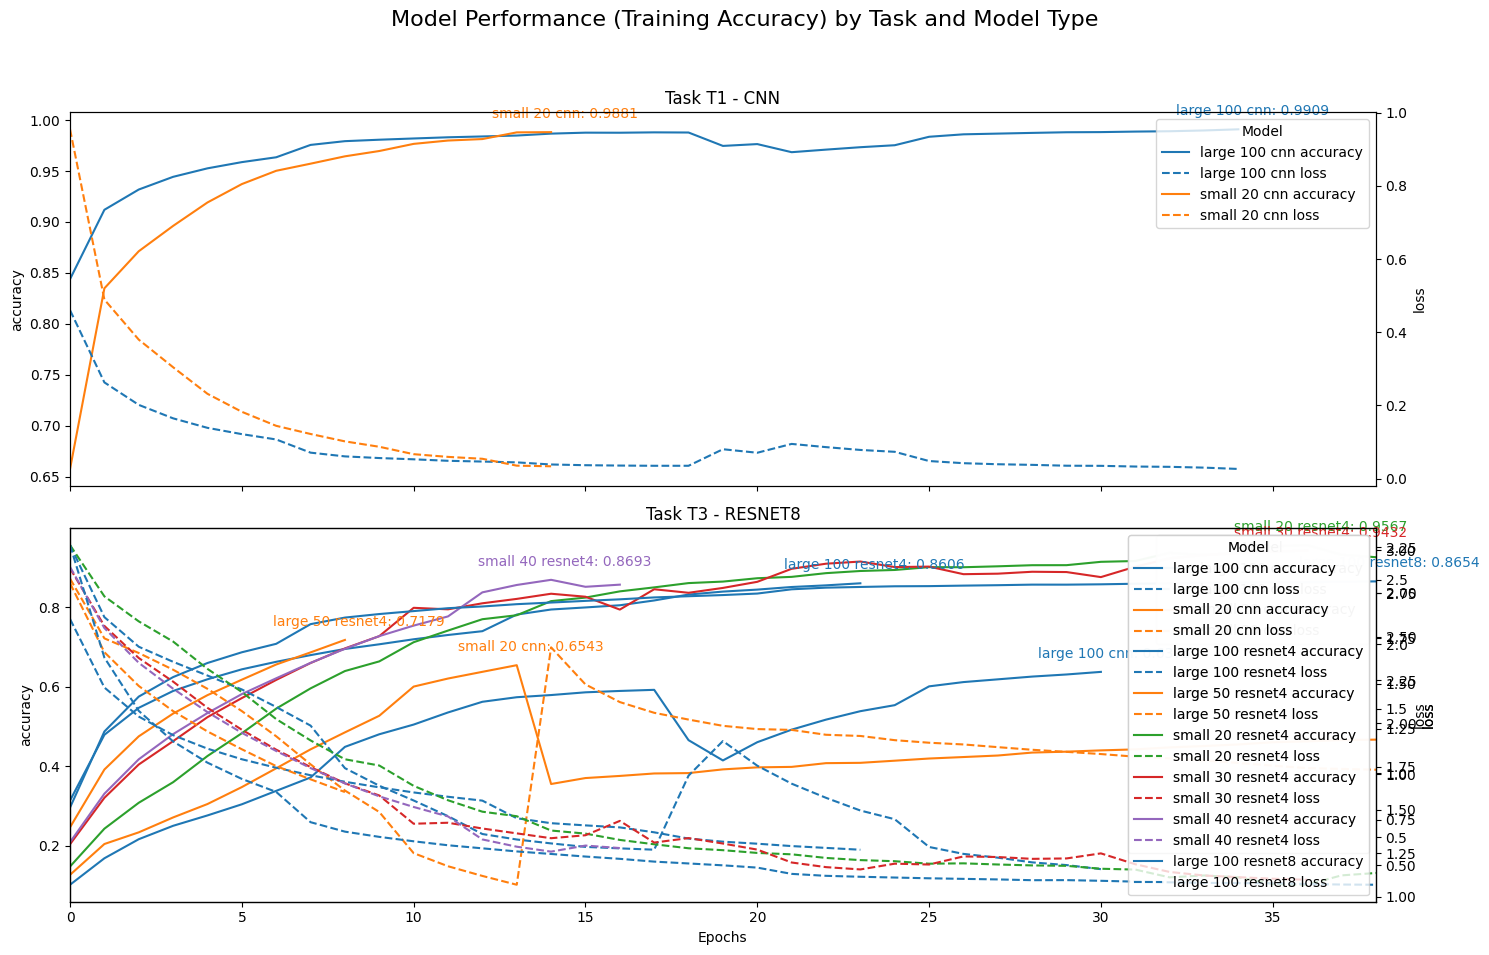

In [296]:
# --- Plotting ---
# Group models by task and model type
model_dirs = [
    d for d in os.listdir(MODEL_DIR) if os.path.isdir(os.path.join(MODEL_DIR, d))
]

grouped_models = defaultdict(lambda: defaultdict(list))
for model_dir in model_dirs:
    parts = model_dir.split("_")
    task = parts[0]
    model_type = parts[-1]
    grouped_models[task][model_type].append(model_dir)

# Figure setup
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
plt.suptitle(
    "Model Performance (Training Accuracy) by Task and Model Type", fontsize=16
)

# Use a colormap to cycle through colors for different models
colors = sns.color_palette("tab10")
linestyles = ["-", "--", "-.", ":"]  # Add more linestyles if needed

# Find the maximum epoch across all models
max_epoch = evaluation_df["epoch"].max()

# Iterate over tasks (t1, t3)
for task, row_axes in zip(grouped_models.keys(), axes):
    # Iterate over model types within the task (cnn, resnet4, etc.)
    for model_type, model_dirs in grouped_models[task].items():
        ax = row_axes
        ax2 = ax.twinx()
        # Define a set to keep track of seen models
        seen_models = set()
        for i, model_dir in enumerate(model_dirs):
            # Get model name for legend
            model_name = model_dir.replace(f"{task}_", "").replace("_", " ")

            # Check if model has already been processed (to avoid duplicates)
            if model_name in seen_models:
                continue
            seen_models.add(model_name)  # Mark model as seen

            # Filter evaluation data for the current model
            model_evaluation_df = evaluation_df[evaluation_df["model_dir"] == model_dir]

            # Find the maximum epoch for the current model
            max_epoch = model_evaluation_df["epoch"].max()

            # Plot lines for each model within the subplot (accuracy and loss)
            for metric, ylabel, ls in zip(
                ["accuracy", "loss"], ["accuracy", "loss"], linestyles
            ):
                sns.lineplot(
                    data=model_evaluation_df,
                    x="epoch",
                    y=metric,
                    markers=True,
                    ax=ax if ylabel == "accuracy" else ax2,
                    color=colors[i],
                    linestyle=ls,
                    legend=False,
                )

                # Calculate and display the highest accuracy if plotting accuracy
                if metric == "accuracy":
                    highest_accuracy_row = model_evaluation_df.nlargest(1, "accuracy")
                    highest_accuracy = highest_accuracy_row["accuracy"].values[0]
                    epoch_of_highest_accuracy = highest_accuracy_row["epoch"].values[0]

                    # Annotate the highest accuracy point
                    ax.annotate(
                        f"{model_name}: {highest_accuracy:.4f}",
                        (epoch_of_highest_accuracy, highest_accuracy),
                        textcoords="offset points",
                        xytext=(10, 10),
                        ha="center",
                        color=colors[i],
                    )
            # Add to legend after both lines are plotted
            for style, label in [("-", "accuracy"), ("--", "loss")]:
                ax.plot(
                    [],
                    [],
                    color=colors[i],
                    linestyle=style,
                    label=f"{model_name} {label}",
                )

        # Additional customizations for the subplot
        ax.set_title(f"Task {task.upper()} - {model_type.upper()}")
        ax.set_ylabel("accuracy")  # Label for the primary (left) y-axis
        ax2.set_ylabel("loss")  # Label for the secondary (right) y-axis

        # Combine legends from both axes (only unique labels)
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        by_label = dict(zip(l1 + l2, h1 + h2))
        ax2.legend(by_label.values(), by_label.keys(), title="Model", loc="upper right")
        ax.set_xlabel("Epochs")
        ax.set_xlim(0, max_epoch)  # Set x-axis limit

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit supertitle
plt.show()

# Save the figure
fig.savefig(f"{MODEL_DIR}/model_performance_training_accuracy.png")

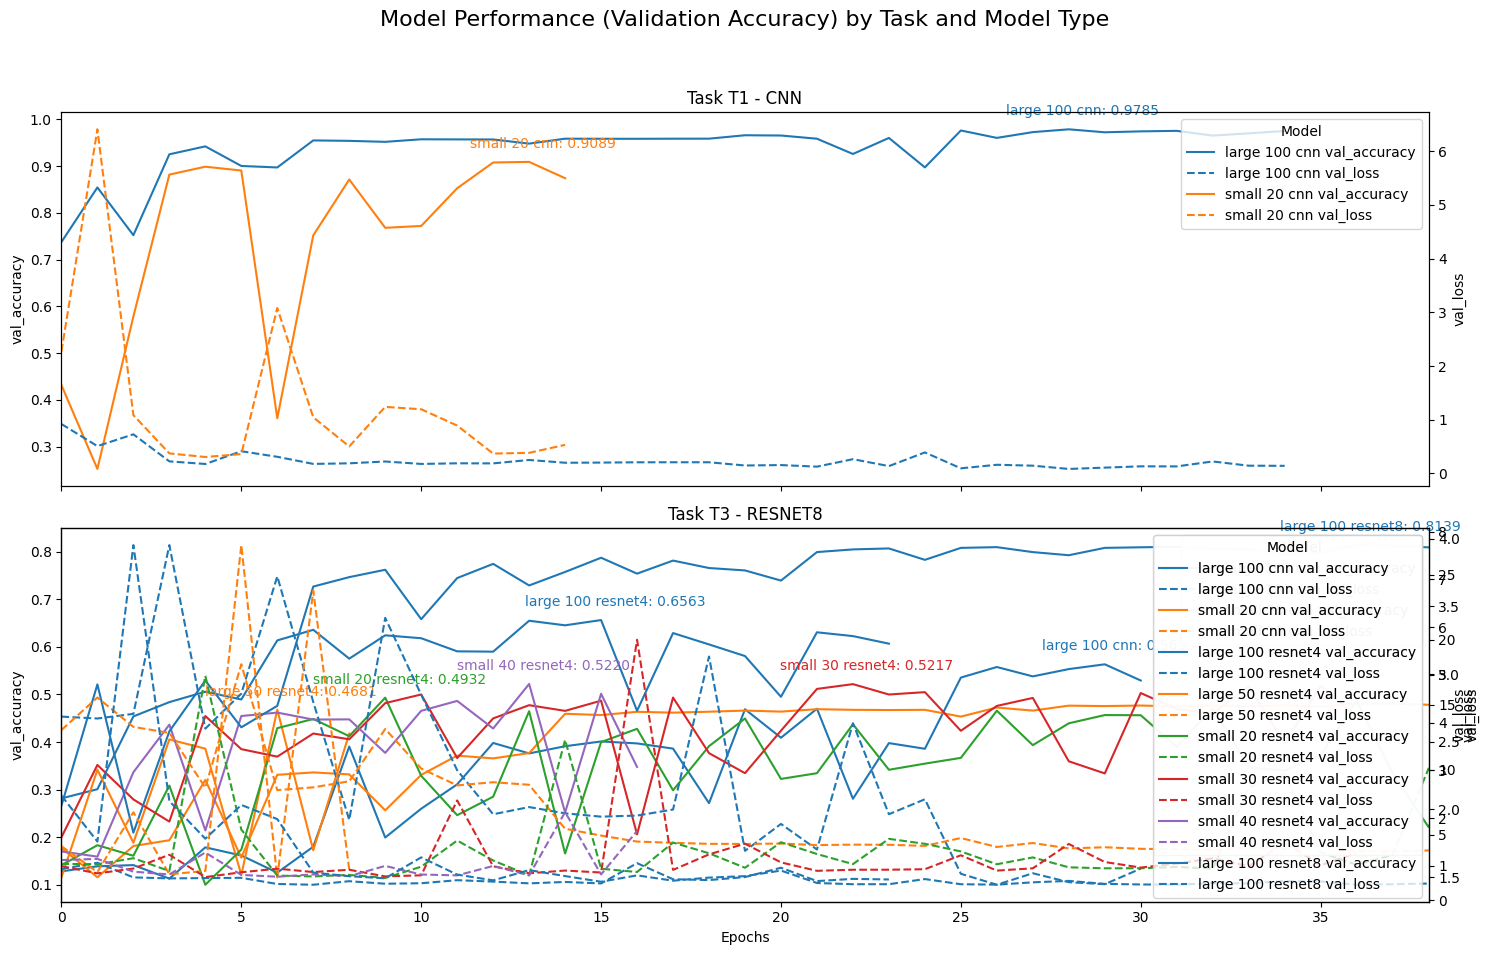

In [297]:
# --- Plotting ---
# Group models by task and model type
model_dirs = [
    d for d in os.listdir(MODEL_DIR) if os.path.isdir(os.path.join(MODEL_DIR, d))
]

grouped_models = defaultdict(lambda: defaultdict(list))
for model_dir in model_dirs:
    parts = model_dir.split("_")
    task = parts[0]
    model_type = parts[-1]
    grouped_models[task][model_type].append(model_dir)

# Figure setup
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
plt.suptitle(
    "Model Performance (Validation Accuracy) by Task and Model Type", fontsize=16
)

# Use a colormap to cycle through colors for different models
colors = sns.color_palette("tab10")
linestyles = ["-", "--", "-.", ":"]  # Add more linestyles if needed

# Find the maximum epoch across all models
max_epoch = evaluation_df["epoch"].max()

# Iterate over tasks (t1, t3)
for task, row_axes in zip(grouped_models.keys(), axes):
    # Iterate over model types within the task (cnn, resnet4, etc.)
    for model_type, model_dirs in grouped_models[task].items():
        ax = row_axes
        ax2 = ax.twinx()
        # Define a set to keep track of seen models
        seen_models = set()
        for i, model_dir in enumerate(model_dirs):
            # Get model name for legend
            model_name = model_dir.replace(f"{task}_", "").replace("_", " ")

            # Check if model has already been processed (to avoid duplicates)
            if model_name in seen_models:
                continue
            seen_models.add(model_name)  # Mark model as seen

            # Filter evaluation data for the current model
            model_evaluation_df = evaluation_df[evaluation_df["model_dir"] == model_dir]

            # Find the maximum epoch for the current model
            max_epoch = model_evaluation_df["epoch"].max()

            # Plot lines for each model within the subplot (accuracy and loss)
            for metric, ylabel, ls in zip(
                ["val_accuracy", "val_loss"], ["val_accuracy", "val_loss"], linestyles
            ):
                sns.lineplot(
                    data=model_evaluation_df,
                    x="epoch",
                    y=metric,
                    markers=True,
                    ax=ax if ylabel == "val_accuracy" else ax2,
                    color=colors[i],
                    linestyle=ls,
                    legend=False,
                )

                # Calculate and display the highest accuracy if plotting accuracy
                if metric == "val_accuracy":
                    highest_accuracy_row = model_evaluation_df.nlargest(
                        1, "val_accuracy"
                    )
                    highest_accuracy = highest_accuracy_row["val_accuracy"].values[0]
                    epoch_of_highest_accuracy = highest_accuracy_row["epoch"].values[0]

                    # Annotate the highest accuracy point
                    ax.annotate(
                        f"{model_name}: {highest_accuracy:.4f}",
                        (epoch_of_highest_accuracy, highest_accuracy),
                        textcoords="offset points",
                        xytext=(10, 10),
                        ha="center",
                        color=colors[i],
                    )
            # Add to legend after both lines are plotted
            for style, label in [("-", "val_accuracy"), ("--", "val_loss")]:
                ax.plot(
                    [],
                    [],
                    color=colors[i],
                    linestyle=style,
                    label=f"{model_name} {label}",
                )

        # Additional customizations for the subplot
        ax.set_title(f"Task {task.upper()} - {model_type.upper()}")
        ax.set_ylabel("val_accuracy")  # Label for the primary (left) y-axis
        ax2.set_ylabel("val_loss")  # Label for the secondary (right) y-axis

        # Combine legends from both axes (only unique labels)
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        by_label = dict(zip(l1 + l2, h1 + h2))
        ax2.legend(by_label.values(), by_label.keys(), title="Model", loc="upper right")
        ax.set_xlabel("Epochs")
        ax.set_xlim(0, max_epoch)  # Set x-axis limit

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit supertitle
plt.show()

# Save the figure
fig.savefig(f"{MODEL_DIR}/model_performance_validation_accuracy.png")

In [298]:
evaluation_df.head()

,epoch,model_dir,accuracy,loss,val_accuracy,val_loss
0,0,t1_large_100_cnn,0.843957,0.460427,0.737488,0.920496
1,0,t1_small_20_cnn,0.657789,0.954896,0.431684,2.269684
2,0,t3_large_100_cnn,0.101408,3.028987,0.128167,2.685800
3,0,t3_large_100_resnet4,0.313485,2.194786,0.281433,2.382964
4,0,t3_large_100_resnet8,0.295793,2.262868,0.266234,2.470675


In [299]:
# Create a color palette based on the number of model types
evaluation_df["model_type"] = evaluation_df["model_dir"].apply(
    lambda x: x.split("_")[-1]
)
unique_model_types = evaluation_df["model_type"].unique()
model_type_colors = sns.color_palette(
    "husl", n_colors=len(unique_model_types)
)  # Use 'husl' color palette for variety
color_map = {
    model_type: color
    for model_type, color in zip(unique_model_types, model_type_colors)
}

In [300]:
# Rename the `model_dir` column before resetting the index
ranked_models = ranked_models.rename(columns={"model_dir": "model_name"})
ranked_models_reset = ranked_models.reset_index()

# Create a color palette based on the number of model names
unique_model_types = ranked_models_reset["model_name"].unique()
model_type_colors = sns.color_palette(
    "husl", n_colors=len(unique_model_types)
)  # Use 'husl' color palette for variety
color_map = {
    model_type: color
    for model_type, color in zip(unique_model_types, model_type_colors)
}

C:\Users\phucv\AppData\Local\Temp\ipykernel_30436\565284320.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked_models = best_accuracy_reset.groupby("task").apply(
C:\Users\phucv\AppData\Local\Temp\ipykernel_30436\565284320.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
C:\Users\phucv\AppData\Local\Temp\ipykernel_30436\565284320.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplo

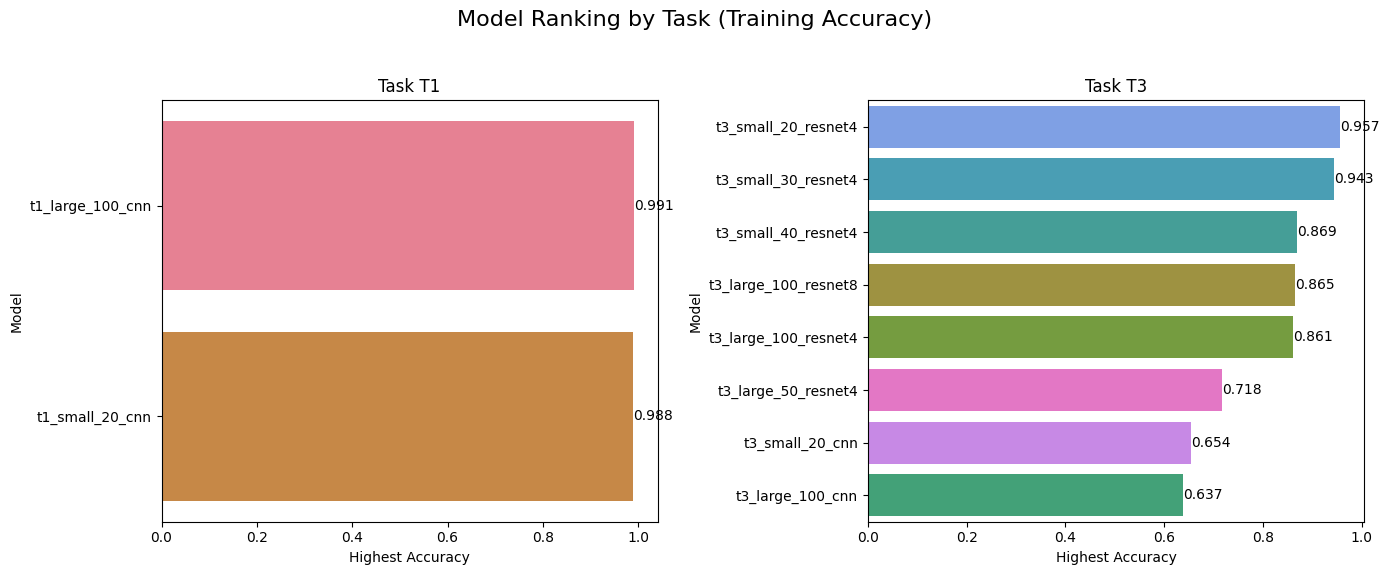

In [301]:
# --- Prepare Data for Ranking ---
best_accuracy = evaluation_df.groupby("model_dir").agg(max_accuracy=("accuracy", "max"))

# Get the task and model_type for each model_dir
best_accuracy["task"] = best_accuracy.index.map(lambda x: x.split("_")[0])
best_accuracy["model_type"] = best_accuracy.index.map(lambda x: x.split("_")[-1])

# Reset the index before the second groupby operation
best_accuracy_reset = best_accuracy.reset_index()

# Sort by max_accuracy within each task
ranked_models = best_accuracy_reset.groupby("task").apply(
    lambda x: x.sort_values("max_accuracy", ascending=False)
)

# Reset the index again to remove 'task' from index
ranked_models = ranked_models.reset_index(drop=True)

# Rename the `model_dir` column
ranked_models = ranked_models.rename(columns={"model_dir": "model_name"})

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns for subplots
plt.suptitle("Model Ranking by Task (Training Accuracy)", fontsize=16)

for i, (task, task_data) in enumerate(ranked_models.groupby("task")):
    ax = axes[i]
    # Get colors based on model type
    colors = [color_map[row["model_name"]] for _, row in task_data.iterrows()]
    barplot = sns.barplot(
        x="max_accuracy",
        y="model_name",
        data=task_data,
        ax=ax,
        palette=colors,
    )
    ax.set_title(f"Task {task.upper()}")
    ax.set_xlabel("Highest Accuracy")
    ax.set_ylabel("Model")

    # Add number annotations to the bars
    for p in barplot.patches:
        width = p.get_width()
        ax.text(
            width,  # x position of text
            p.get_y() + p.get_height() / 2,  # y position of text
            "{:.3f}".format(width),  # text value
            va="center",  # vertical alignment of text
        )

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit supertitle
plt.show()

# Save the figure
fig.savefig(f"{MODEL_DIR}/model_ranking_training_accuracy_with_annotation.png")

C:\Users\phucv\AppData\Local\Temp\ipykernel_30436\1698968742.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked_models = best_val_accuracy_reset.groupby("task").apply(
C:\Users\phucv\AppData\Local\Temp\ipykernel_30436\1698968742.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
C:\Users\phucv\AppData\Local\Temp\ipykernel_30436\1698968742.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

 

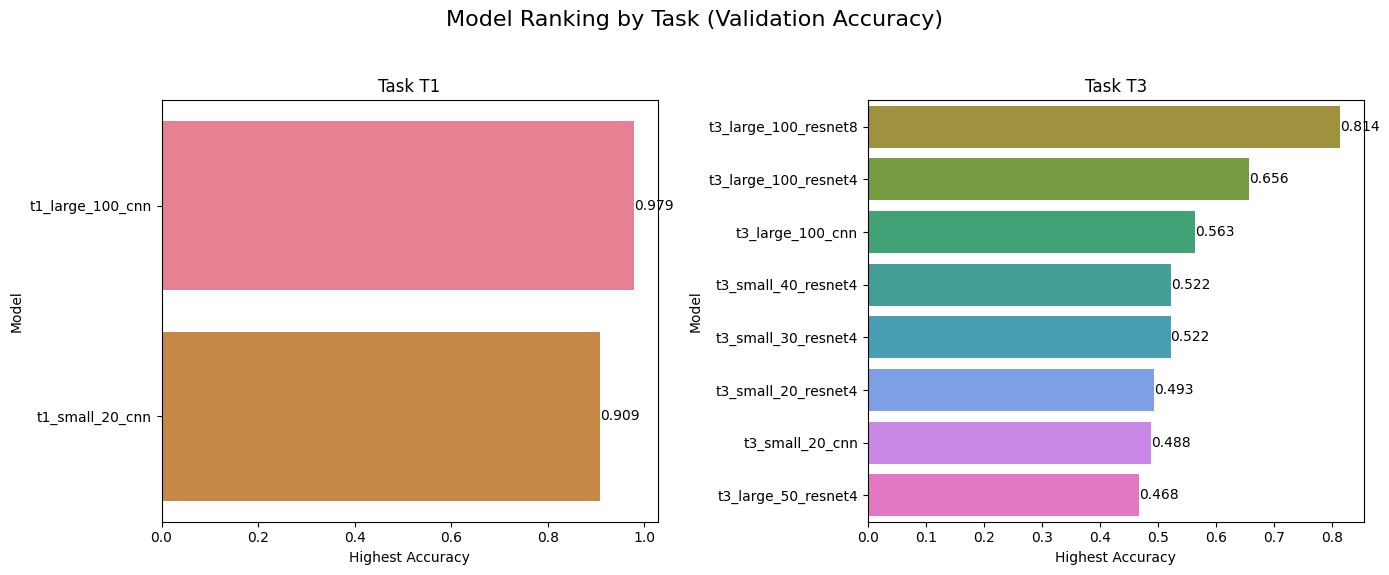

In [302]:
# --- Prepare Data for Ranking ---
best_val_accuracy = evaluation_df.groupby("model_dir").agg(
    max_val_accuracy=("val_accuracy", "max")
)

# Get the task and model_type for each model_dir
best_val_accuracy["task"] = best_val_accuracy.index.map(lambda x: x.split("_")[0])
best_val_accuracy["model_type"] = best_val_accuracy.index.map(
    lambda x: x.split("_")[-1]
)

# Reset the index before the second groupby operation
best_val_accuracy_reset = best_val_accuracy.reset_index()

# Sort by max_val_accuracy within each task
ranked_models = best_val_accuracy_reset.groupby("task").apply(
    lambda x: x.sort_values("max_val_accuracy", ascending=False)
)

# Reset the index again to remove 'task' from index
ranked_models = ranked_models.reset_index(drop=True)

# Rename the `model_dir` column
ranked_models = ranked_models.rename(columns={"model_dir": "model_name"})

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns for subplots
plt.suptitle("Model Ranking by Task (Validation Accuracy)", fontsize=16)

for i, (task, task_data) in enumerate(ranked_models.groupby("task")):
    ax = axes[i]
    # Get colors based on model type
    colors = [color_map[row["model_name"]] for _, row in task_data.iterrows()]
    barplot = sns.barplot(
        x="max_val_accuracy",
        y="model_name",
        data=task_data,
        ax=ax,
        palette=colors,
    )
    ax.set_title(f"Task {task.upper()}")
    ax.set_xlabel("Highest Accuracy")
    ax.set_ylabel("Model")

    # Add number annotations to the bars
    for p in barplot.patches:
        width = p.get_width()
        ax.text(
            width,  # x position of text
            p.get_y() + p.get_height() / 2,  # y position of text
            "{:.3f}".format(width),  # text value
            va="center",  # vertical alignment of text
        )

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit supertitle
plt.show()

# Save the figure
fig.savefig(f"{MODEL_DIR}/model_ranking_validation_accuracy_with_annotation.png")